# Sanity check: synthetic manifolds 

In [23]:
from typing import Callable, Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [24]:
EPS = 1e-9
DADAPY_GRID_RANGE_MAX = 64
RAND_SEED = 42
np.random.seed(RAND_SEED)

In [25]:
try:
    from IsoScore.IsoScore import IsoScore as _isoscore_fn
except Exception:
    try:
        from IsoScore import IsoScore as _isoscore_fn
    except Exception:
        _isoscore_fn = None
        _missing.append("IsoScore")
_missing: List[str] = []

In [26]:
try:
    try:
        from dadapy import Data
    except Exception:
        from dadapy.data import Data  
except Exception:
    Data = None 
    _missing.append("dadapy")

In [27]:
try:
    from skdim.id import MOM, TLE, CorrInt, FisherS, lPCA, MLE, MADA, ESS
except Exception:
    MOM = TLE = CorrInt = FisherS = lPCA = MLE = MADA = ESS = None  # type: ignore
    _missing.append("scikit-dimension (skdim)")

In [28]:
if _missing:
    raise ImportError(
        "Missing required dependencies: "
        + ", ".join(_missing)
        + "\n\nInstall with:\n"
        + "  pip install IsoScore dadapy scikit-dimension\n"
    )

In [29]:
def _center(X: np.ndarray) -> np.ndarray:
    return X - X.mean(0, keepdims=True)


def _eigvals_from_X(X: np.ndarray) -> np.ndarray:
    """Eigenvalues of covariance up to a constant via SVD of centered X (descending)."""
    Xc = _center(X.astype(np.float32, copy=False))
    _, S, _ = np.linalg.svd(Xc, full_matrices=False)
    lam = (S ** 2).astype(np.float64)
    lam.sort()
    return lam[::-1]


def _jitter_unique(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Add tiny noise if there are duplicate rows (helps NN-based estimators)."""
    if np.unique(X, axis=0).shape[0] < X.shape[0]:
        X = X + np.random.normal(scale=eps, size=X.shape).astype(X.dtype)
    return X

In [30]:
def _iso_once(X: np.ndarray) -> float:
    return float(_isoscore_fn(X))


def _sf_once(X: np.ndarray) -> float:
    lam = np.linalg.eigvalsh(np.cov(X.T, ddof=0))
    gm = np.exp(np.mean(np.log(lam + EPS)))
    am = float(lam.mean() + EPS)
    return float(gm / am)


def _vmf_kappa_once(X: np.ndarray) -> float:
    """Closed-form approximation of vMF concentration κ (anisotropy↑)."""
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + EPS)
    R = float(np.linalg.norm(Xn.mean(axis=0)))
    d = Xn.shape[1]
    if R < 1e-9:
        return 0.0
    return float(max(R * (d - R**2) / (1.0 - R**2 + EPS), 0.0))


def _erank_once(X: np.ndarray) -> float:
    lam = _eigvals_from_X(X)
    p = lam / (lam.sum() + EPS)
    H = float(-(p * np.log(p + EPS)).sum())
    return float(np.exp(H))


def _pr_once(X: np.ndarray) -> float:
    lam = _eigvals_from_X(X)
    s1 = float(lam.sum())
    s2 = float((lam ** 2).sum())
    return float((s1 ** 2) / (s2 + EPS))


def _stable_rank_once(X: np.ndarray) -> float:
    lam = _eigvals_from_X(X)
    return float(lam.sum() / (lam.max() + EPS))


def _pca99_once(X: np.ndarray) -> float:
    """Global PCA dimension: # PCs to explain 99% variance."""
    lam = _eigvals_from_X(X)
    c = np.cumsum(lam)
    thr = c[-1] * 0.99
    return float(np.searchsorted(c, thr) + 1)


def _dadapy_twonn_once(X: np.ndarray) -> float:
    d = Data(coordinates=_jitter_unique(X))  # type: ignore
    id_est, _, _ = d.compute_id_2NN()
    return float(id_est)


def _dadapy_gride_once(X: np.ndarray) -> float:
    d = Data(coordinates=_jitter_unique(X))  # type: ignore
    d.compute_distances(maxk=DADAPY_GRID_RANGE_MAX)
    ids, _, _ = d.return_id_scaling_gride(range_max=DADAPY_GRID_RANGE_MAX)
    return float(ids[-1])


def _skdim_fit_dim(X: np.ndarray, est) -> float:
    est.fit(_jitter_unique(X))
    return float(getattr(est, "dimension_", np.nan))


def _skdim_lpca_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, lPCA(ver="FO"))


def _skdim_lpca99_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, lPCA(ver="ratio", alphaRatio=0.99))


def _skdim_mle_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, MLE())


def _skdim_mom_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, MOM())


def _skdim_tle_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, TLE())


def _skdim_corrint_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, CorrInt())


def _skdim_fishers_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, FisherS())


def _skdim_mada_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, MADA())


def _skdim_ess_once(X: np.ndarray) -> float:
    return _skdim_fit_dim(X, ESS())

In [31]:
METRICS: List[Tuple[str, str, Callable[[np.ndarray], float]]] = [
    # Isotropy
    ("IsoScore", "iso", _iso_once),
    ("Spectral Flatness", "sf", _sf_once),
    ("vMF κ", "vmf_kappa", _vmf_kappa_once),
    # Linear ID
    ("Effective Rank", "erank", _erank_once),
    ("Participation Ratio", "pr", _pr_once),
    ("Stable Rank", "stable_rank", _stable_rank_once),
    ("PCAFO (lPCA)", "lpca", _skdim_lpca_once),
    ("PCA0.99", "pca99", _pca99_once),
    ("lPCA99 (ratio)", "lpca99", _skdim_lpca99_once),
    # Nonlinear ID
    ("TwoNN", "twonn", _dadapy_twonn_once),
    ("GRIDE", "gride", _dadapy_gride_once),
    ("MOM", "mom", _skdim_mom_once),
    ("TLE", "tle", _skdim_tle_once),
    ("CorrInt", "corrint", _skdim_corrint_once),
    ("FisherS", "fishers", _skdim_fishers_once),
    ("MLE", "mle", _skdim_mle_once),
    ("MADA", "mada", _skdim_mada_once),
    ("ESS", "ess", _skdim_ess_once),
]


In [32]:
def make_isotropic_gaussian(n: int = 4000, d: int = 16) -> np.ndarray:
    rng = np.random.default_rng(RAND_SEED)
    return rng.normal(size=(n, d)).astype(np.float32)


def make_anisotropic_gaussian(n: int = 4000, d: int = 16, cond: float = 100.0) -> np.ndarray:
    """Diagonal Gaussian with covariance condition number ~cond (variance ratio)."""
    rng = np.random.default_rng(RAND_SEED)
    # std ratio sqrt(cond) -> variance ratio cond
    stds = np.geomspace(np.sqrt(cond), 1.0, d).astype(np.float32)
    X = rng.normal(size=(n, d)).astype(np.float32) * stds[None, :]
    return X


def make_linear_subspace_gaussian(
    n: int = 4000,
    ambient: int = 64,
    intrinsic: int = 4,
    noise: float = 1e-3,
) -> np.ndarray:
    rng = np.random.default_rng(RAND_SEED)
    Q, _ = np.linalg.qr(rng.normal(size=(ambient, intrinsic)))
    Z = rng.normal(size=(n, intrinsic))
    X = Z @ Q.T
    X += rng.normal(scale=noise, size=X.shape)
    return X.astype(np.float32)


def make_swiss_roll(n: int = 4000, noise: float = 0.0) -> np.ndarray:
    """Classic 2D swiss roll embedded in R^3."""
    rng = np.random.default_rng(RAND_SEED)
    t = 1.5 * np.pi * (1.0 + 2.0 * rng.random(n))
    x = t * np.cos(t)
    z = t * np.sin(t)
    y = 21.0 * rng.random(n)
    X = np.stack([x, y, z], axis=1).astype(np.float32)
    if noise > 0:
        X += rng.normal(scale=noise, size=X.shape).astype(np.float32)
    return X


def default_manifolds(n: int = 4000) -> Dict[str, Dict[str, object]]:
    return {
        "IG-16": {
            "X": make_isotropic_gaussian(n=n, d=16),
            "true_id": 16,
            "notes": "isotropic Gaussian in R^16",
        },
        "AG-16": {
            "X": make_anisotropic_gaussian(n=n, d=16, cond=100.0),
            "true_id": 16,
            "notes": "anisotropic Gaussian in R^16 (cond≈100)",
        },
        "LR-4-in-64": {
            "X": make_linear_subspace_gaussian(n=n, ambient=64, intrinsic=4, noise=1e-3),
            "true_id": 4,
            "notes": "4D linear subspace in R^64 (+tiny noise)",
        },
        "SR-2": {
            "X": make_swiss_roll(n=n, noise=0.0),
            "true_id": 2,
            "notes": "2D swiss roll manifold in R^3",
        },
    }

In [33]:
N = 200
manifolds = default_manifolds(n=N)
manifold_order = list(manifolds.keys())
metric_order = [lab for (lab, _, _) in METRICS]

rows = []
failures = []

for m_name in manifold_order:
    X = manifolds[m_name]["X"]  # type: ignore
    assert isinstance(X, np.ndarray)
    for metric_label, metric_key, fn in METRICS:
        try:
            val = float(fn(X))
        except Exception as e:
            val = float("nan")
            failures.append((m_name, metric_key, repr(e)))
        rows.append(
            {
                "manifold": m_name,
                "metric": metric_key,
                "metric_label": metric_label,
                "value": val,
            }
        )

df = pd.DataFrame(rows)

In [36]:
pivot = (
    df.pivot(index="metric_label", columns="manifold", values="value")
      .reindex(index=metric_order, columns=manifold_order)
)

vals = pivot.to_numpy(dtype=float)
norm = np.zeros_like(vals, dtype=float)


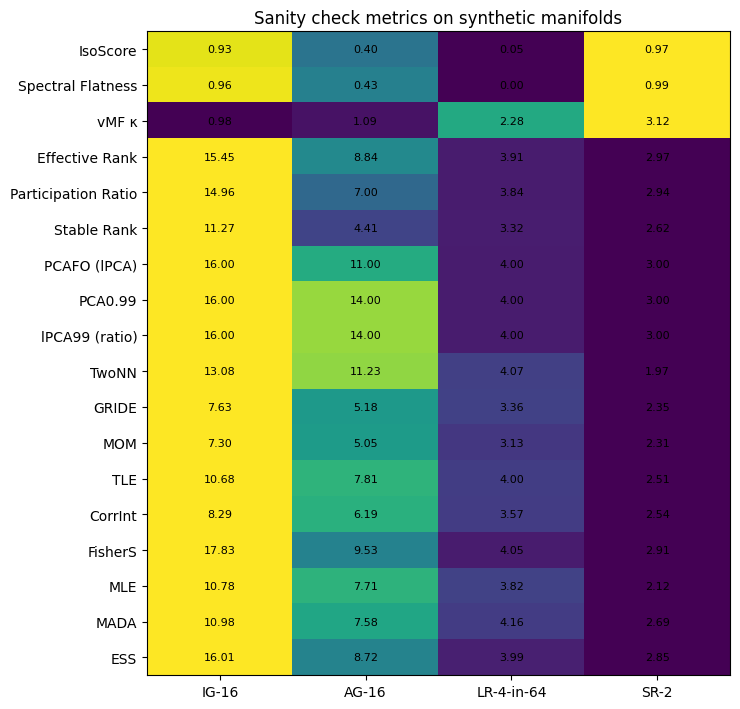

In [37]:
for i in range(vals.shape[0]):
    row = vals[i]
    finite = np.isfinite(row)
    if finite.sum() == 0:
        continue
    rmin, rmax = float(np.nanmin(row)), float(np.nanmax(row))
    if rmax > rmin:
        norm[i] = (row - rmin) / (rmax - rmin)
    else:
        norm[i] = 0.0

fig_w = max(7.5, 1.35 * len(manifold_order))
fig_h = max(6.0, 0.40 * len(metric_order))

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.imshow(norm, aspect="auto", interpolation="nearest")

ax.set_xticks(np.arange(len(manifold_order)))
ax.set_xticklabels(manifold_order)
ax.set_yticks(np.arange(len(metric_order)))
ax.set_yticklabels(metric_order)
ax.set_title("Sanity check metrics on synthetic manifolds")

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        v = vals[i, j]
        s = f"{v:.2f}" if np.isfinite(v) else "—"
        ax.text(j, i, s, ha="center", va="center", fontsize=8)

fig.tight_layout()